# an Overall code for CF and head views analysis for all csvs

imports

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
import openpyxl
import os
import re
import ggplot
from openpyxl import load_workbook
import xlsxwriter



parameters

experiments_folder: the folder with all the experiments we want to plot and make csvs for

regex: the text we take from logs in each results to extract the threshold

plot_kwards: the args for the results plot

save..: if we want to save the plot/csv data of the results

plot folder:dest path to save the plots

mean_std_folder: dest path to csv data

In [45]:
experiments_folder = Path('/home/administrator/experiments/all_ids/500_ids')
# experiments_folder = Path('/home/administrator/experiments/frontal_vs_variable')
regex =' (.*) threshold\\nlayer\s*\\n(\d*)(\s+)(\d*.\d*)(\s+)(\d*.\d*)\\n(\d*)(\s+)(\d*.\d*)(\s+)(\d*.\d*)\\n(\d*)(\s+)(\d*.\d*)(\s+)(\d*.\d*)'
plot_kwargs={'grid':True,'figsize':(20,8), 'fontsize':12}
save_views_plot = 0
save_cf_plot = 0
save_views_csv = 0
save_cf_csv = 0
save_mean_views_csv = 1
save_mean_cf_csv = 1
save_std_views_csv = 0
save_std_cf_csv = 0
save_se_views_csv = 1
save_se_cf_csv = 1
mean_std_folder=''
plots_folder = '/home/administrator/plot_results/all_ids/500_test/500_ids_num_changed/'
# plots_folder = '/home/administrator/plot_results/frontal_vs_variable/'
mean_folder_views='/home/administrator/plot_results/all_ids/500_test/500_ids_num_changed/csv/mean/views/'
std_folder_views='/home/administrator/plot_results/all_ids/500_test/500_ids_num_changed/csv/std/views/'
se_folder_views='/home/administrator/plot_results/all_ids/500_test/500_ids_num_changed/csv/se/views/'
mean_folder_cf='/home/administrator/plot_results/all_ids/500_test/500_ids_num_changed/csv/mean/cf/'
std_folder_cf='/home/administrator/plot_results/all_ids/500_test/500_ids_num_changed/csv/std/cf/'
se_folder_cf='/home/administrator/plot_results/all_ids/500_test/500_ids_num_changed/csv/se/cf/'

csv_list=[]
add_to_title = 'gaus_2'
excel_title = '500_ids'

make the csvs list

In [46]:
for experiment in experiments_folder.iterdir():
    csv_path=''
#     csv_path = (os.path.join(Path(experiment),'vgg16/results/comparisons_with_fc7_linear.csv'))
    csv_path = (os.path.join(Path(experiment),'vgg16/results/comparisons_with_fc7_linear_blurred_Gaus_2.csv'))
    csv_list.append(csv_path)
# csv_list = ['/home/administrator/experiments/500_ids/500_ids_300_train/vgg16/results/comparisons_with_fc7_linear.csv']
# csv_list = ['/home/administrator/experiments//1000_ids_20_train/vgg16/results/comparisons_with_fc7_linear.csv']
# csv_list = ['/home/administrator/experiments/500_ids/500_ids_100_train/vgg16/results/comparisons_with_fc7_linear_blurred_Gaus_2.csv']

    results of the threshold extraction:
    results.group(2) = 38
    results.group(4) = accuracy (38) 
    results.group(6) = threshold (38)
    
    results.group(7) = 37
    results.group(9) = accuracy (37) 
    results.group(11) = threshold (37)
    
    results.group(12) = 39
    results.group(14) = accuracy (39) 
    results.group(16) = threshold (39)

500_ids_200
500_ids_50
500_ids_300
500_ids_10
500_ids_20
500_ids_100
500_ids_5
500_ids_1


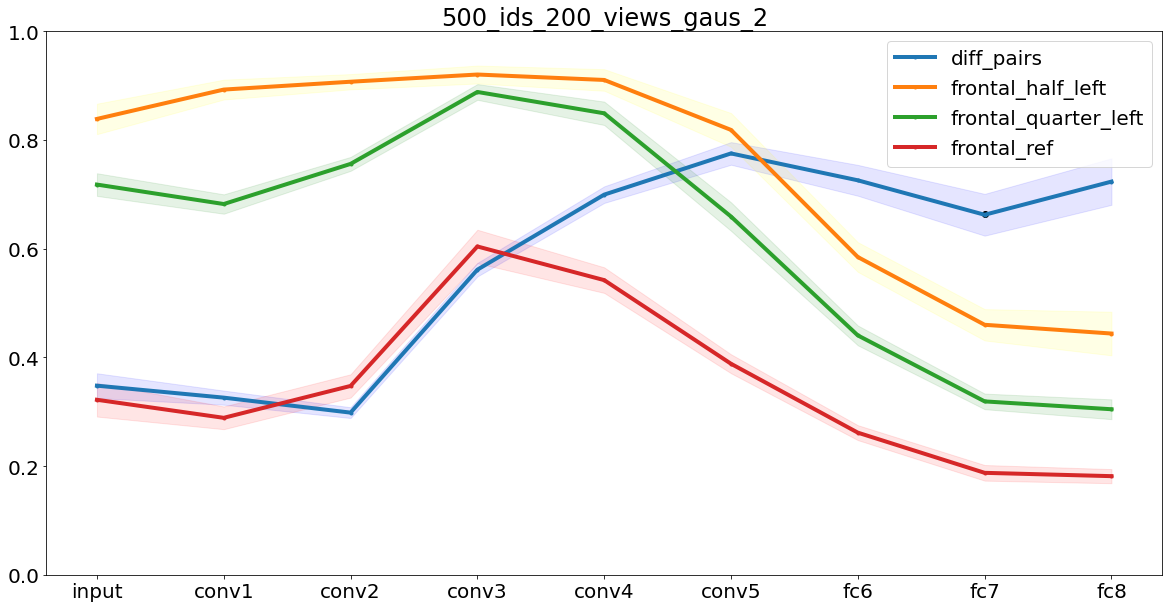

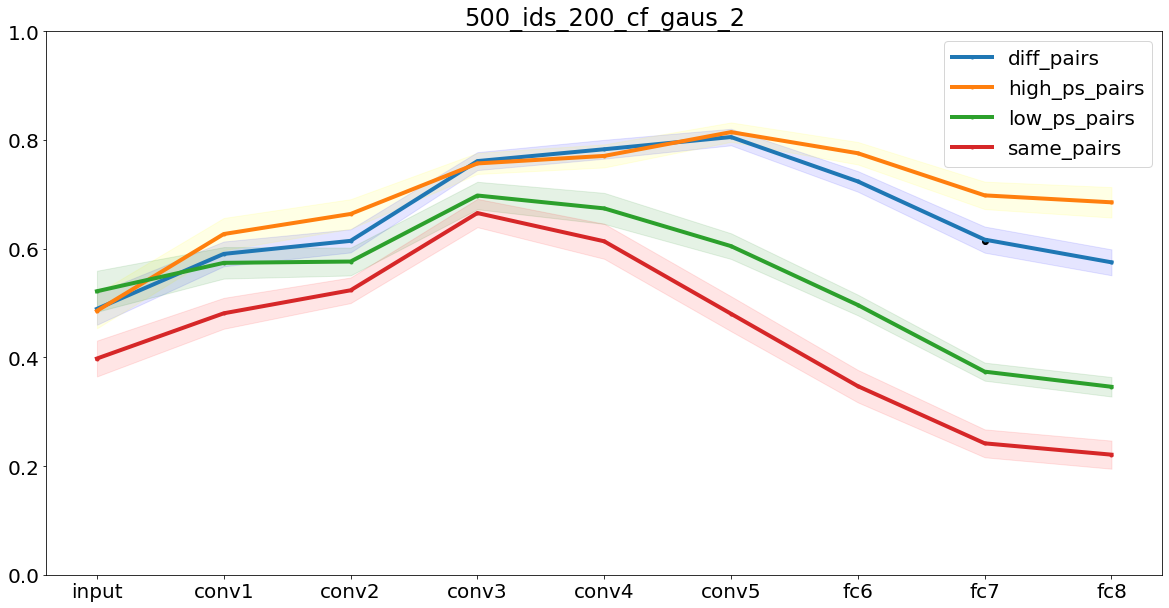

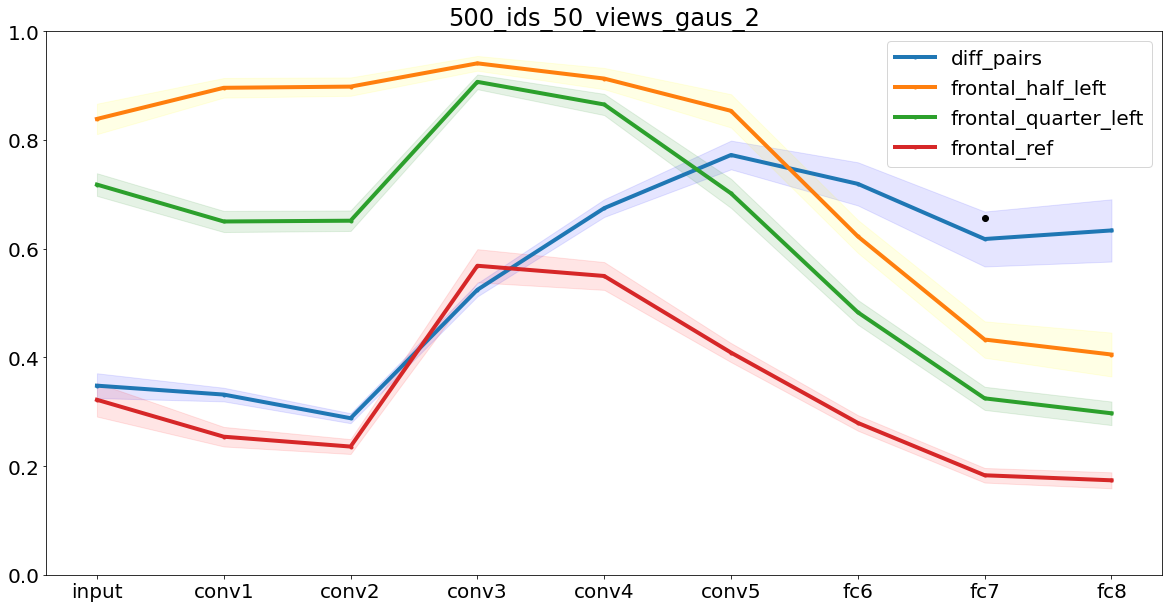

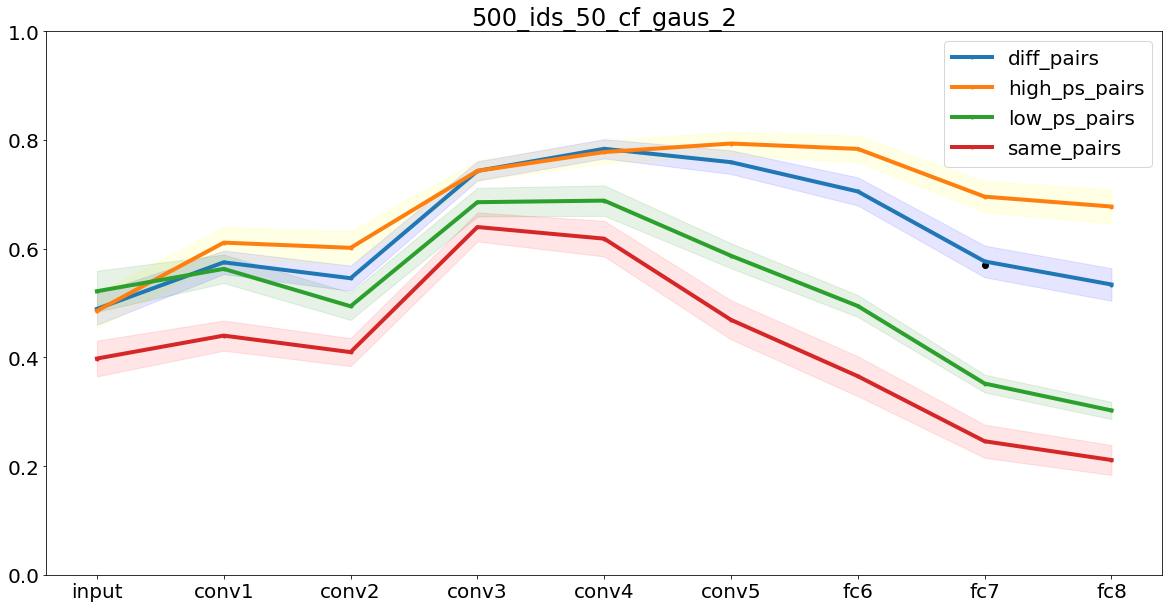

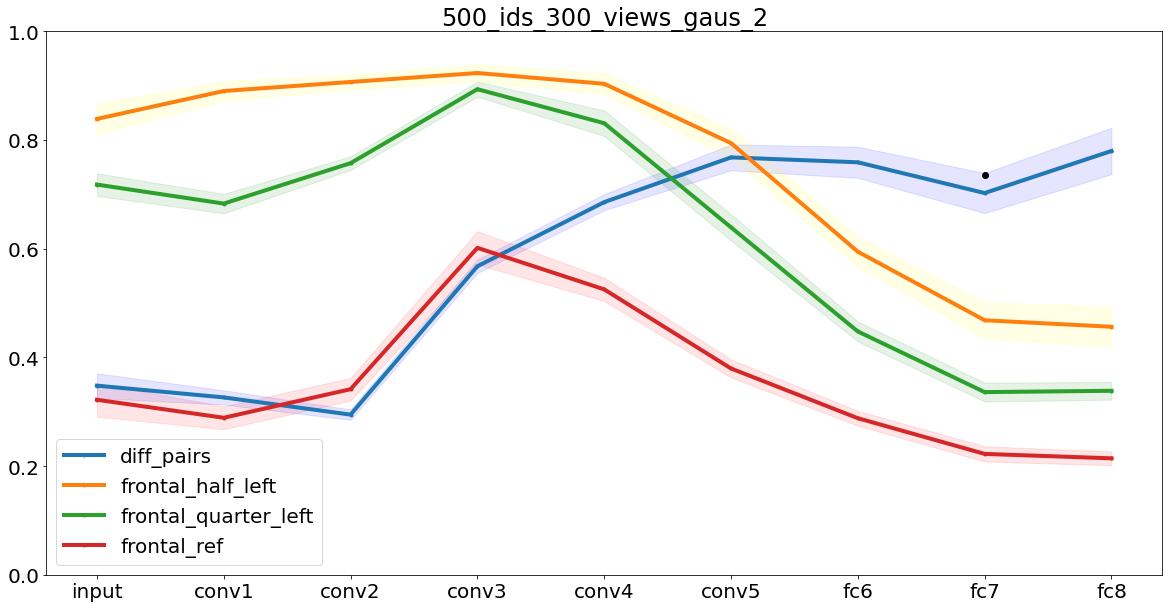

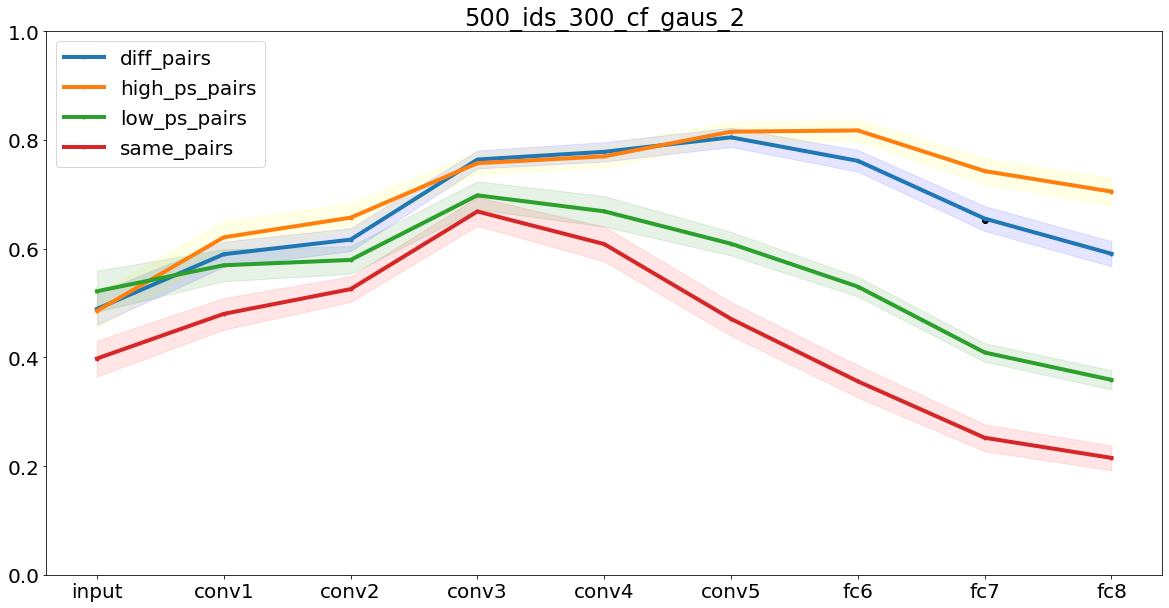

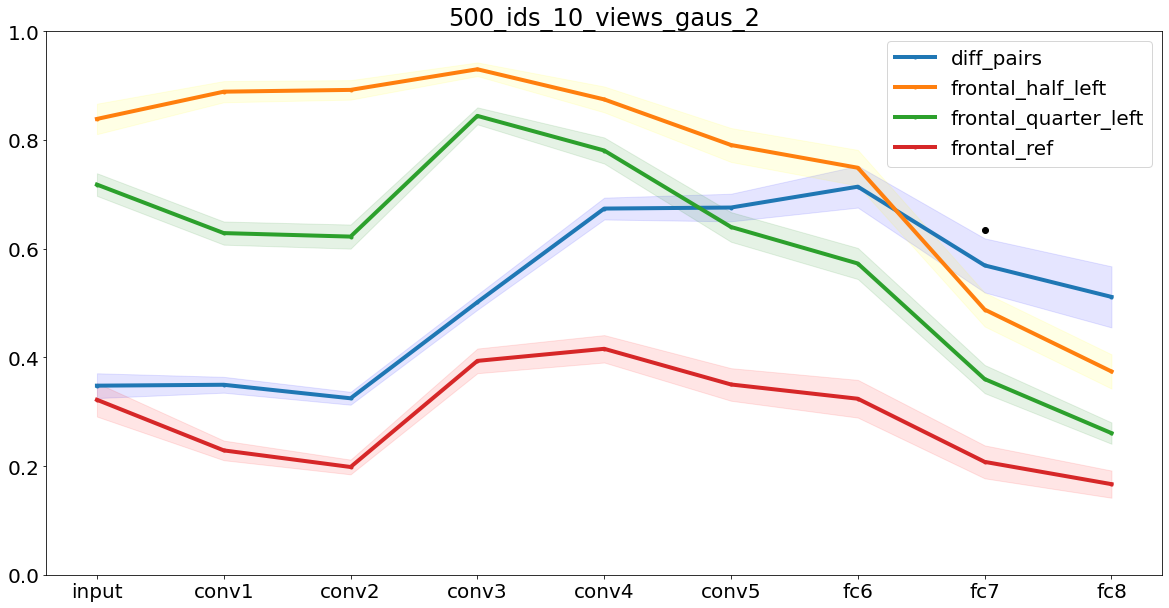

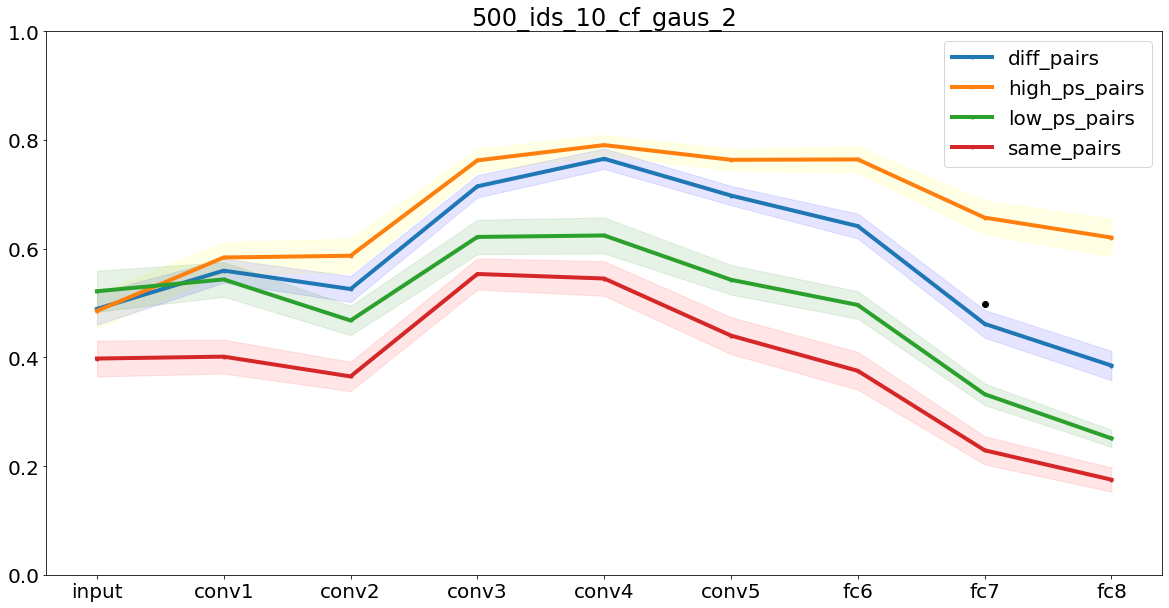

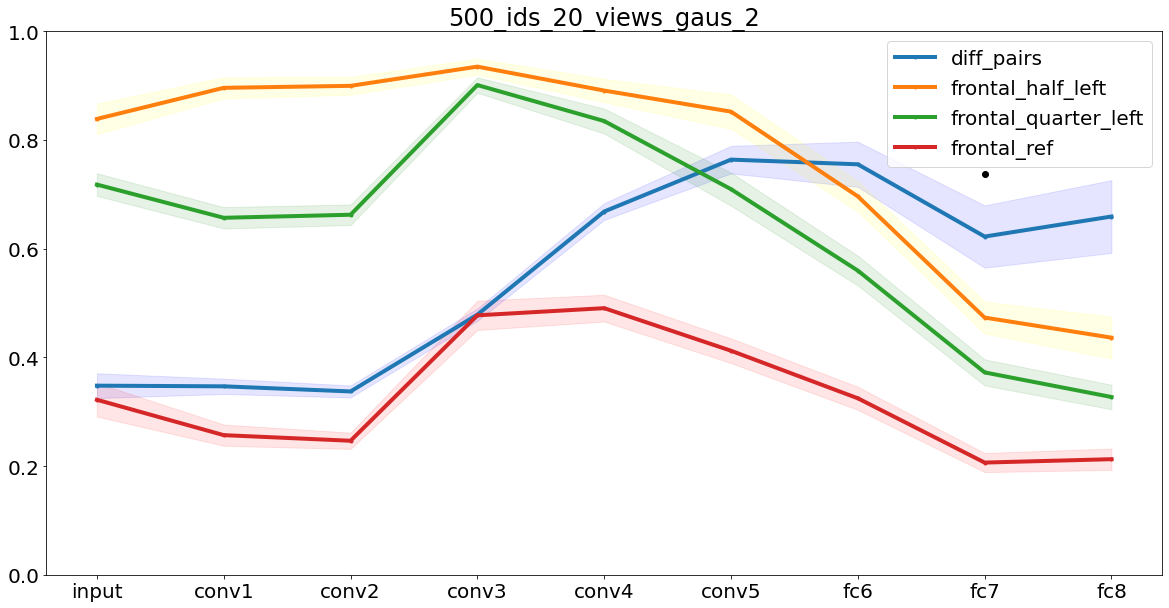

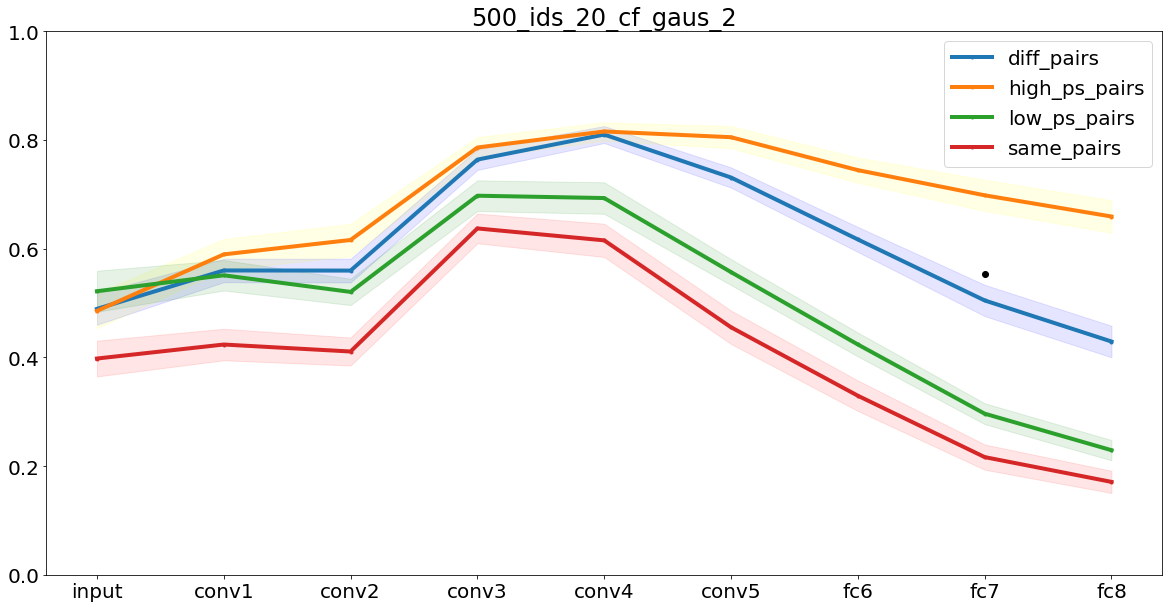

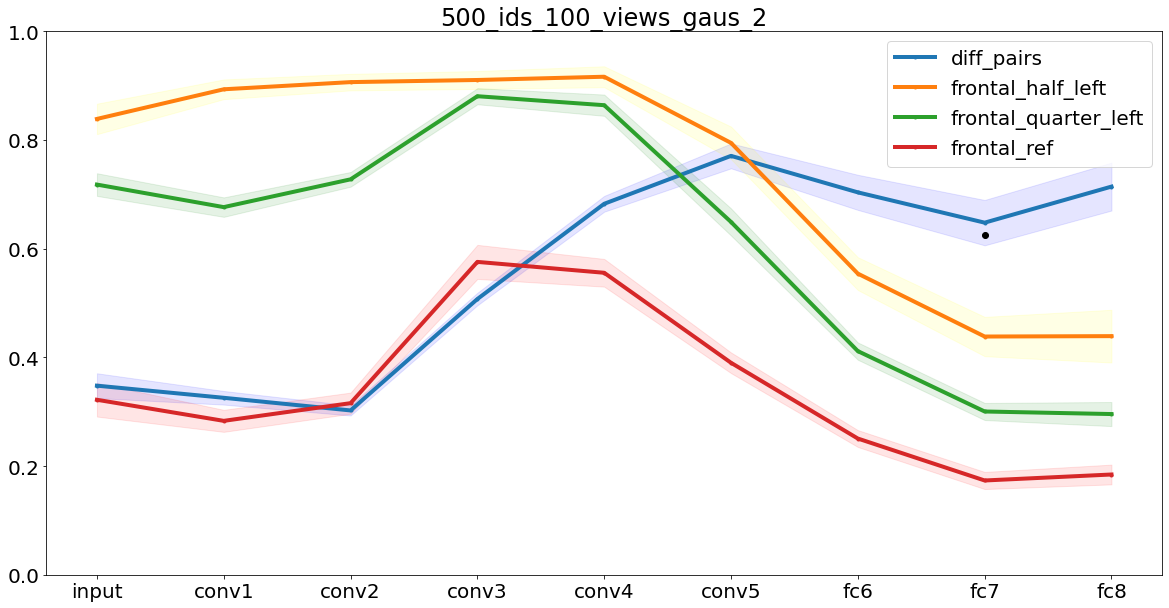

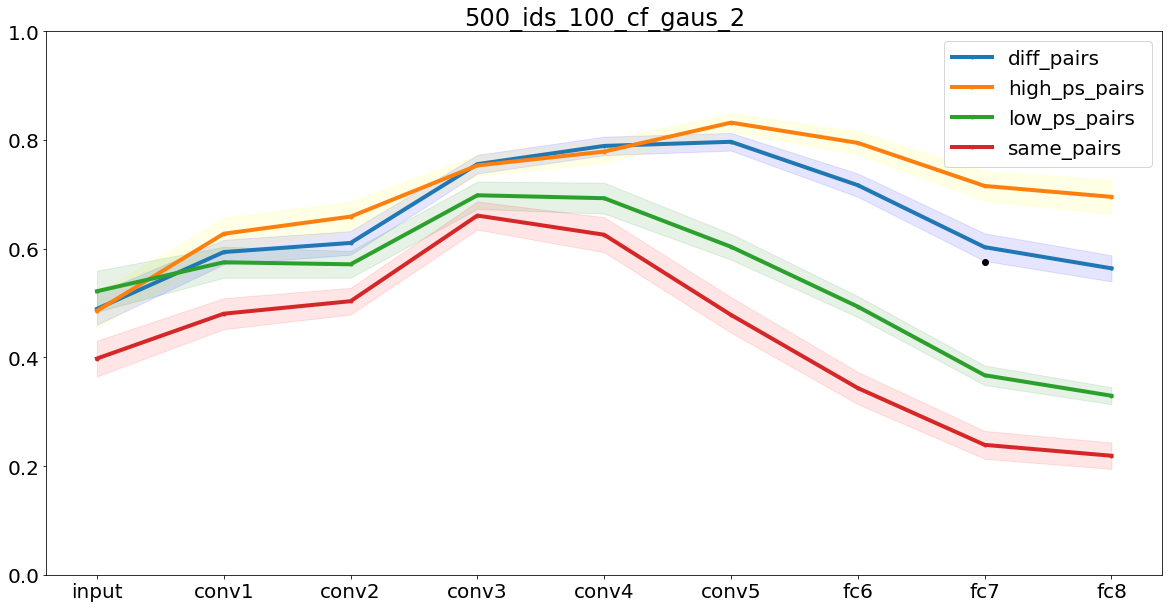

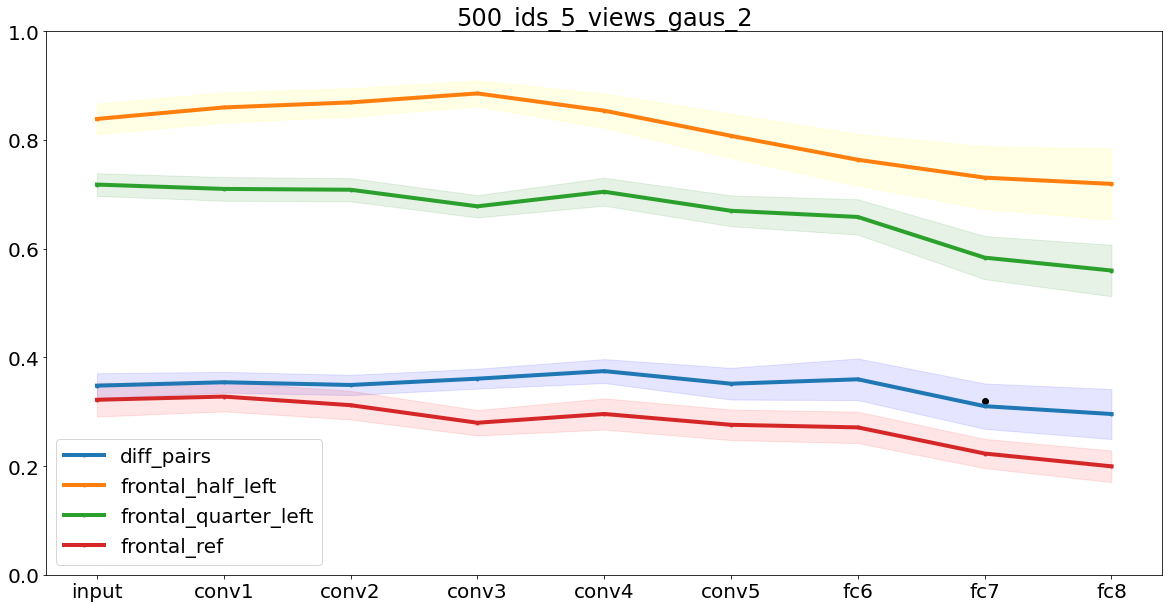

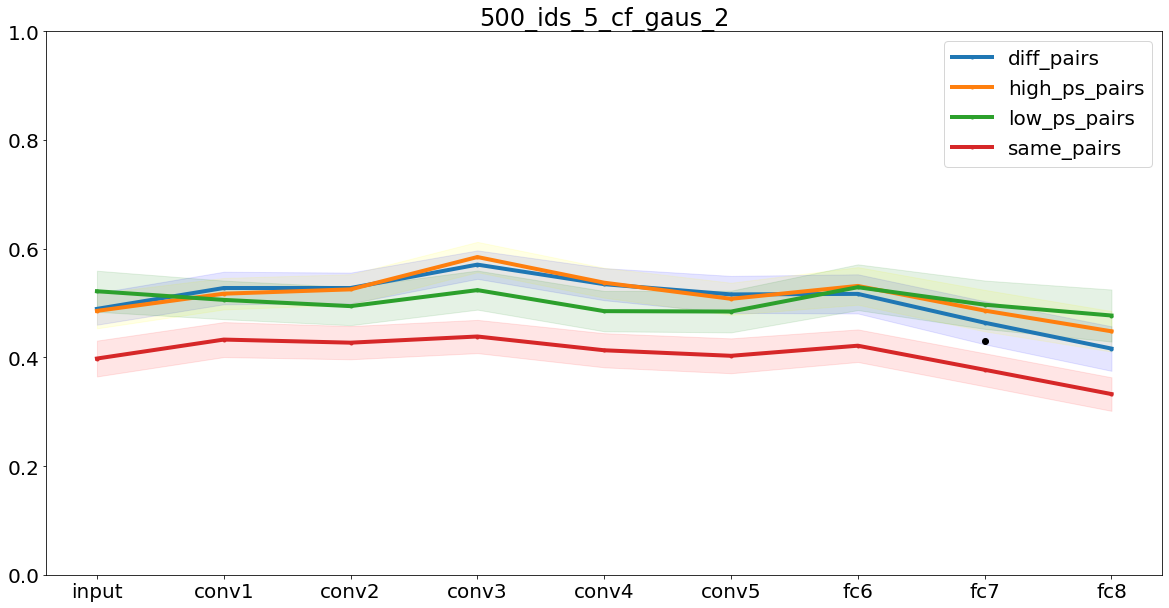

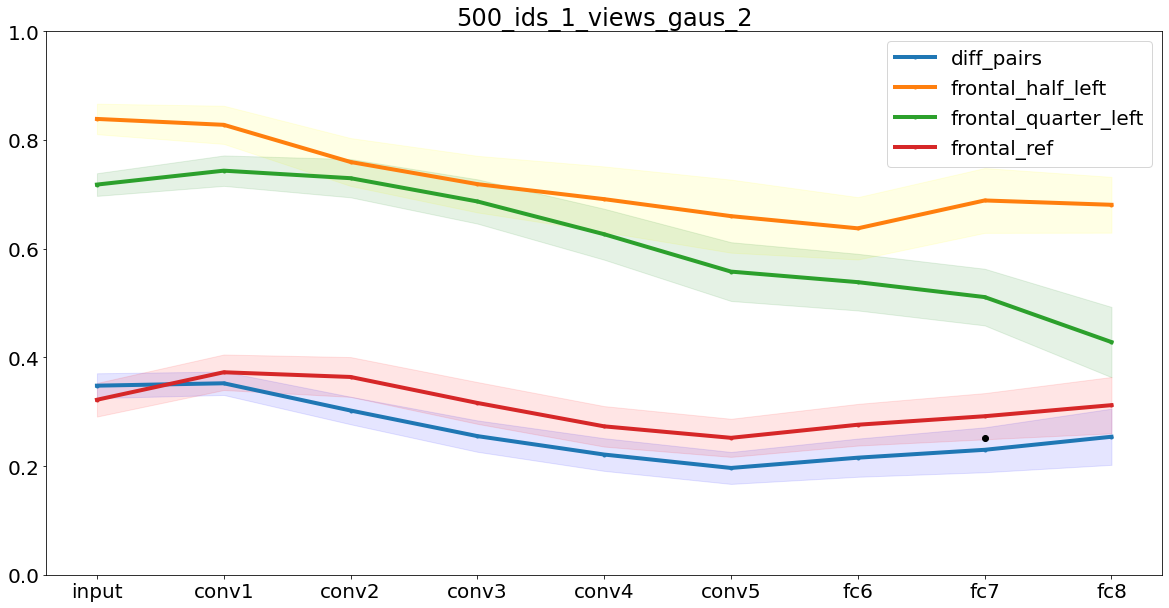

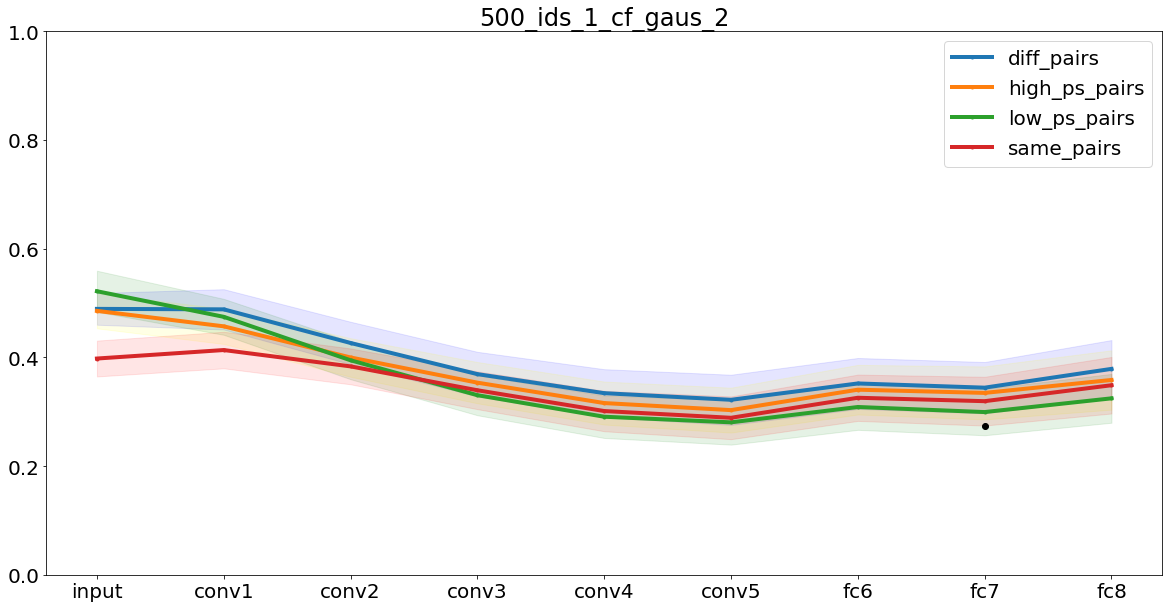

In [47]:
for csv_file in csv_list:
    df = pd.read_csv(csv_file)
    splited = csv_file.split('/') 
    #normal:
#     base_title = splited[splited.index('experiments')+2]
#     base_title = (base_title.split('img'))[0][:-1]
# #for 1000:
#     base_title = (base_title.split('train'))[0]
# for 500:
    base_title = splited[splited.index('experiments')+3]
    base_title = (base_title.split('img'))[0][:-1]
    print(base_title)
    
    p = os.path.join(Path(csv_file).parents[1], 'results')
    if os.path.exists(os.path.join(p, 'logs.csv')):
        csv_threshold = 1
        threshold_file = os.path.join(p, 'logs.csv')
    else:
        csv_threshold = 0
        threshold_file = os.path.join(Path(csv_file).parents[2], 'logs')
    #extract threshold
    with open(threshold_file) as fo:
        if csv_threshold == 0:
            logs = fo.read()
            results = re.search(regex,logs)
            threshold37 = float(results.group(11)) 
        else:
            df_threshold = pd.read_csv(fo)
            threshold37 = df_threshold.loc[1,'threshold']

    
    # change unnamed column to 'pairs'
    df = df.rename(columns = {'Unnamed: 0':'pairs'})
    
    #split the tuples to two columns
    df_splited = df['pairs'].str.split(',', expand=True)

    #adding   
    df.insert(loc=0, column='img1', value=df_splited[0] )
    df.insert(loc=1, column='img2', value=df_splited[1] )


    # Dropping old Name columns 
    df.drop(columns =["pairs"], inplace = True) 
    
    #reorder columns by layer order
    df = df[['img1', 'img2', 'input', 'conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6', 'fc7', 'fc8','type' ]]


    ##################head views###################
    
    title = base_title +'_views_'+add_to_title

    #change frontal-ref to frontal_ref
    df['type'] = df['type'].replace(['frontal-ref'],'frontal_ref')


    #change frontal-quarter_left to frontal_quarter_left
    df['type'] = df['type'].replace(['frontal-quarter_left'],'frontal_quarter_left')


    #change frontal-half_left to frontal_half_left
    df['type'] = df['type'].replace(['frontal-half_left'],'frontal_half_left')

    #remove  HPS,LPS,SAME type.
    # df = df[df.type.str.contains("same_pairs|frontal|diff_pairs")]
    df1 = df[df.type.str.contains("frontal|diff_pairs")]

    df2 = df1[df1.type.str.contains("same_pairs|diff_pairs")]
    # df1 = df[df['type'] =='diff_pairs'|df['type']=='same_pairs']
    df3 = df2[df2.img1.str.contains("CM")] 
    # df3 = df[df['type'] !='diff_pairs'&df['type'] !='same_pairs']
    df4 = df1[~df1.type.str.contains("same_pairs|diff_pairs")]

    df_views = pd.concat([df3,df4])
    df_views.reset_index()
    max_value_df = df_views.max()
    max_value_df
    df_views = df_views.reset_index(drop=True)
    
    df_views = df_views.drop(columns=['img1', 'img2'])
    normalized_threshold_views = threshold37/max_value_df['fc7']
    
    for x in df_views.drop(columns=['type']).columns:
        df_views[x]= (df_views[x]/df_views[x].max()) 
    
    #df of size of each type
    size_df_views = df_views.groupby(['type']).count()
    sqrt_size_views = np.sqrt(size_df_views)
    
    #mean of each columns by type of pairs
    means_df_views = df_views.groupby(['type']).mean()
    means_df_views = means_df_views.rename_axis("layers", axis="columns")
    means_df_views = means_df_views.transpose()

    
    std_views = df_views.groupby(['type']).std()
    std_views = std_views.transpose()
    
    #standard error of mean
    se_views = std_views.transpose().div(sqrt_size_views).transpose()
    
    #combine means and std df to one:
    columns = means_df_views.columns.copy()
    rows =  means_df_views.index.copy()
    header = pd.MultiIndex.from_product([columns,
                                         ['mean','STD']],
                                        names=['type','mean/STD'])
    df_means_std = pd.DataFrame( 
                      index=rows, 
                      columns=header)

    df_means_std[('diff_pairs','mean')] = means_df_views.diff_pairs.copy()
    df_means_std[('diff_pairs','STD')] = std_views.diff_pairs.copy()
    
    df_means_std[('frontal_half_left','mean')] = means_df_views.frontal_half_left.copy()
    df_means_std[('frontal_half_left','STD')] = std_views.frontal_half_left.copy()
    
    df_means_std[('frontal_quarter_left','mean')] = means_df_views.frontal_quarter_left.copy()
    df_means_std[('frontal_quarter_left','STD')] = std_views.frontal_quarter_left.copy()
    
    df_means_std[('frontal_ref','mean')] = means_df_views.frontal_ref.copy()
    df_means_std[('frontal_ref','STD')] = std_views.frontal_ref.copy()
    
    
    
    #save to csv/excel

    if (save_views_csv == 1):

        excel_book = mean_std_folder+add_to_title+'/'+excel_title+'.xlsx'
        sheet = title+'_mean_std'
        if  os.path.exists(excel_book):
            with pd.ExcelWriter(excel_book, engine='openpyxl', mode='a') as writer:  
                df_means_std.to_excel(writer, sheet_name=sheet)

        else:
            with pd.ExcelWriter(excel_book) as writer:  
                df_means_std.to_excel(writer, sheet_name=sheet)
    if (save_mean_views_csv == 1):
        excel_book = mean_folder_views+add_to_title+'/'+excel_title+'.xlsx'
        sheet = title+'_mean'
        if  os.path.exists(excel_book):
            with pd.ExcelWriter(excel_book, engine='openpyxl', mode='a') as writer:  
                means_df_views.to_excel(writer, sheet_name=sheet)

        else:
            with pd.ExcelWriter(excel_book) as writer:  
                means_df_views.to_excel(writer, sheet_name=sheet)
                
    if (save_std_views_csv == 1):
        excel_book = std_folder_views+add_to_title+'/'+excel_title+'.xlsx'
        sheet = title+'_std'
        if  os.path.exists(excel_book):
            with pd.ExcelWriter(excel_book, engine='openpyxl', mode='a') as writer:  
                std_views.to_excel(writer, sheet_name=sheet)

        else:
            with pd.ExcelWriter(excel_book) as writer:  
                std_views.to_excel(writer, sheet_name=sheet)
    
    if (save_se_views_csv == 1):
        excel_book = se_folder_views+add_to_title+'/'+excel_title+'.xlsx'
        sheet = title+'_se'
        if  os.path.exists(excel_book):
            with pd.ExcelWriter(excel_book, engine='openpyxl', mode='a') as writer:  
                se_views.to_excel(writer, sheet_name=sheet)

        else:
            with pd.ExcelWriter(excel_book) as writer:  
                se_views.to_excel(writer, sheet_name=sheet)
    


    
#     #plot
#     plot = means_df_views.plot(**plot_kwargs, title = title, ylim = [0,1], lw=4)
#     plt.scatter(7, normalized_treshold_views, color='black')

    #plot
    #with std bars
#     score_lower_limit1 = means_df_views - std_views
#     score_upper_limit1 = means_df_views + std_views
    #with SE bars
    score_lower_limit1 = means_df_views - se_views
    score_upper_limit1 = means_df_views + se_views
    COLORS = "blue", "yellow", "green", "red"
    
    param_fig1, param_ax1 = plt.subplots(sharex = 'all', figsize=(20,10))
    plt.ylim(0, 1)
    param_ax1.set_title(title)

    param_ax1.plot(means_df_views, marker='.', lw=4)
    plt.legend( ['diff_pairs', 'frontal_half_left','frontal_quarter_left','frontal_ref'])#?????



    for i, col in enumerate(means_df_views.columns):
            param_ax1.fill_between(means_df_views.index,
                              score_lower_limit1[col],
                              score_upper_limit1[col],
                              color=COLORS[i],
                              alpha=0.1)
    param_ax1.scatter(7, normalized_threshold_views, color='black')
    matplotlib.rcParams.update({'font.size': 20})
#     plt.rcParams["font.family"] = "Humor Sans"

    
    #save plot
    if (save_views_plot==1):
        plt.savefig(plots_folder+'/head_views/'+title)
    



    
    #################critical features#################
    title = base_title +'_cf_'+add_to_title
    
    #remove all last rows - save only DIFF,HPS,LPS,SAME type.
    df_cf = df[~df.type.str.contains("frontal")]
    
    #max values df
    max_value_df = df_cf.max()
    
    df_cf = df_cf.reset_index(drop=True)
    df_cf = df_cf.drop(columns=['img1', 'img2'])
    
    #normalized threshold
    normalized_threshold_cf = threshold37/max_value_df['fc7']
    
    #
    for x in df_cf.drop(columns=['type']).columns:
        df_cf[x]= (df_cf[x]/df_cf[x].max()) 
    
    #df of size of each type
    size_df_cf = df_cf.groupby(['type']).count()
    sqrt_size_cf = np.sqrt(size_df_cf)
    
    #mean of each columns by type of pairs
    means_df_cf = df_cf.groupby(['type']).mean()
    means_df_cf = means_df_cf.rename_axis("layers", axis="columns")
    means_df_cf = means_df_cf.transpose()
    
    #standard deviation
    std_cf = df_cf.groupby(['type']).std()
    std_cf = std_cf.transpose()
    
    #standard error of mean
    se_cf = std_cf.transpose().div(sqrt_size_cf).transpose()
    
    #combine means and std df to one:
    columns_cf = means_df_cf.columns.copy()
    rows_cf =  means_df_cf.index.copy()
    header_cf = pd.MultiIndex.from_product([columns_cf,
                                         ['mean','STD']],
                                        names=['type','mean/STD'])
    df_means_std_cf = pd.DataFrame( 
                      index=rows_cf, 
                      columns=header_cf)

    df_means_std_cf[('diff_pairs','mean')] = means_df_cf.diff_pairs.copy()
    df_means_std_cf[('diff_pairs','STD')] = std_cf.diff_pairs.copy()
    
    df_means_std_cf[('high_ps_pairs','mean')] = means_df_cf.high_ps_pairs.copy()
    df_means_std_cf[('high_ps_pairs','STD')] = std_cf.high_ps_pairs.copy()
    
    df_means_std_cf[('low_ps_pairs','mean')] = means_df_cf.low_ps_pairs.copy()
    df_means_std_cf[('low_ps_pairs','STD')] = std_cf.low_ps_pairs.copy()
    
    df_means_std_cf[('same_pairs','mean')] = means_df_cf.same_pairs.copy()
    df_means_std_cf[('same_pairs','STD')] = std_cf.same_pairs.copy()
    
    
    #save to csv/excel
    
    if (save_cf_csv == 1):

        excel_book = mean_std_folder+add_to_title+'/'+excel_title+'.xlsx'
        sheet = title+'_mean_std'
        if  os.path.exists(excel_book):
            with pd.ExcelWriter(excel_book, engine='openpyxl', mode='a') as writer:  
                df_means_std_cf.to_excel(writer, sheet_name=sheet)

        else:
            with pd.ExcelWriter(excel_book) as writer:  
                df_means_std_cf.to_excel(writer, sheet_name=sheet)
    if (save_mean_cf_csv == 1):
        excel_book = mean_folder_cf+add_to_title+'/'+excel_title+'.xlsx'
        sheet = title+'_mean'
        if  os.path.exists(excel_book):
            with pd.ExcelWriter(excel_book, engine='openpyxl', mode='a') as writer:  
                means_df_cf.to_excel(writer, sheet_name=sheet)

        else:
            with pd.ExcelWriter(excel_book) as writer:  
                means_df_cf.to_excel(writer, sheet_name=sheet)

    if (save_std_cf_csv == 1):
        excel_book = std_folder_cf+add_to_title+'/'+excel_title+'.xlsx'
        sheet = title+'_std'
        if  os.path.exists(excel_book):
            with pd.ExcelWriter(excel_book, engine='openpyxl', mode='a') as writer:  
                std_cf.to_excel(writer, sheet_name=sheet)

        else:
            with pd.ExcelWriter(excel_book) as writer:  
                std_cf.to_excel(writer, sheet_name=sheet)
                
    if (save_se_cf_csv == 1):
        excel_book = se_folder_cf+add_to_title+'/'+excel_title+'.xlsx'
        sheet = title+'_se'
        if  os.path.exists(excel_book):
            with pd.ExcelWriter(excel_book, engine='openpyxl', mode='a') as writer:  
                se_cf.to_excel(writer, sheet_name=sheet)

        else:
            with pd.ExcelWriter(excel_book) as writer:  
                se_cf.to_excel(writer, sheet_name=sheet)


    
    
    
#     if (save_cf_csv == 1):
#         df_means_std_cf.to_csv(mean_std_folder+title+'_mean_std')
#         # df.to_excel("output.xlsx", sheet_name='Sheet_name_1')  
#     if (save_mean_cf_csv == 1):
# #         means_df_cf.to_csv(mean_folder+'/mean/'+title+'_mean')
#     # df.to_excel("output.xlsx", sheet_name='Sheet_name_1') 
#         means_df_cf.to_excel(mean_folder+'mean/'+add_to_title+'/'+excel_title+'.xlsx', sheet_name=title+'_mean') 

#     if (save_std_cf_csv == 1):
#         std_cf.to_csv(std_folder+'/std/'+title+'_std')
#     # df.to_excel("output.xlsx", sheet_name='Sheet_name_1') 

    #plot
    score_lower_limit = means_df_cf - se_cf
    score_upper_limit = means_df_cf + se_cf
    COLORS = "blue", "yellow", "green", "red"
    
    param_fig, param_ax = plt.subplots(sharex = 'all', figsize=(20,10))
    plt.ylim(0, 1)
    param_ax.set_title(title)

    param_ax.plot(means_df_cf, marker='.', lw=4)
    plt.legend( ['diff_pairs', 'high_ps_pairs','low_ps_pairs','same_pairs'])#?????


    
    
#     arr1 =param_ax.plot(means_df_cf.diff_pairs, marker='*', lw=4, label = 'diff_pairs')
#     arr2 = param_ax.plot(means_df_cf.high_ps_pairs, marker='*', lw=4, label = 'hps')
#     arr3 = param_ax.plot(means_df_cf.low_ps_pairs, marker='*', lw=4, label = 'lps')
#     arr4 =param_ax.plot(means_df_cf.same_pairs, marker='*', lw=4, label = 'same')
#     plt.legend([arr1, arr2, arr3, arr4], ['diff_pairs','high_ps_pairs','low_ps_pairs','same_pairs'])
#     plot = means_df_cf.plot(**plot_kwargs, title = title, ylim = [0,1], lw=4)





    for i, col in enumerate(means_df_cf.columns):
            param_ax.fill_between(means_df_cf.index,
                              score_lower_limit[col],
                              score_upper_limit[col],
                              color=COLORS[i],
                              alpha=0.1)
    param_ax.scatter(7, normalized_threshold_cf, color='black')
    matplotlib.rcParams.update({'font.size': 20})
#     plt.rcParams["font.family"] = "Humor Sans"


        

    #save plot
    if (save_cf_plot==1):
        plt.savefig(plots_folder+'/cf/'+title)
